In [1]:
"""
    Student:        Byron Dowling
    Class:          Computer Vision (CSE 60535)
    Term:           University of Notre Dame, Fall 2023
    Assignment:     Practical #2 6000-Level Task
"""

import cv2
import numpy as np
from skimage import measure
from skimage.measure import find_contours
import matplotlib.pyplot as plt

In [2]:
# Read the image into grayscale
sample = cv2.imread('breakfast.png')
sample_small = cv2.resize(sample, (640, 480))

original = sample_small

# Convert the original image to grayscale
sample_grey = cv2.cvtColor(sample, cv2.COLOR_BGR2GRAY)

# Show the grey scale image
sample_grey_small = cv2.resize(sample_grey, (640, 480))

In [6]:
# Select parameters of your Gabor kernel here:
ksize = 40
sigma = 3.3
theta = np.arange(0, (np.pi*(3/4)), (np.pi/4)) 
lbd = 7.0 
gamma = 1.0 
psi = 0.0 

# generate kernels for each theta
kernels = []
for angle in theta:
    kernel = cv2.getGaborKernel((ksize, ksize), sigma, angle, lbd, gamma, psi, ktype=cv2.CV_32F)
    
    # Normalize the kernel and remove the DC component
    kernel /= kernel.sum()
    kernel -= kernel.mean()
    kernels.append(kernel)

# compute maximum across kernels
max_gabor_filter = np.zeros(sample_grey.shape)

gabor_filter = ""

for kernel in kernels:
    # Apply kernel to image
    gabor_filter = cv2.filter2D(sample_grey, cv2.CV_8UC3, kernel)

    # Display Gabor filter of image for each iteration
    gabor_filter_small = cv2.resize(gabor_filter, (640, 480))

    # compute maximum of all filters
    np.maximum(max_gabor_filter, gabor_filter, out=max_gabor_filter)

In [7]:
# Convert the original image to HSV
# and take H channel for further calculations
sample_hsv = cv2.cvtColor(sample, cv2.COLOR_BGR2HSV)
sample_h = sample_hsv[:, :, 0]

sample_small = cv2.resize(sample_h, (640, 480))

# *** TASK *** It's a good place to apply morphological operations to the "binary_image"
# Binarize the image using Otsu's method
ret1, binary_image = cv2.threshold(src=sample_grey, thresh=0, maxval=255, type=cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Floodfill
im_floodfill = binary_image.copy()
h, w = binary_image.shape[:2]
mask = np.zeros((h+2,w+2), np.uint8)
cv2.floodFill(im_floodfill, mask, (0, 0), 255)
im_floodfill_inv = cv2.bitwise_not(im_floodfill)
binary_image = binary_image | im_floodfill_inv

sample_small = cv2.resize(src=binary_image, dsize=(640, 480))

se_size = 8
kernel = np.ones((se_size,se_size),np.uint8)

morph_ops = [cv2.MORPH_OPEN, cv2.MORPH_ERODE, cv2.MORPH_ERODE,
             cv2.MORPH_ERODE] 

morphed = cv2.morphologyEx(binary_image, morph_ops[0] , kernel=kernel)

for index in range(1,len(morph_ops)):
    morphed = cv2.morphologyEx(morphed, morph_ops[index], kernel=kernel)

sample_small = cv2.resize(morphed, (640, 480))

In [8]:
# Find connected pixels and compose them into objects
labels = measure.label(morphed)

# Calculate features for each object
properties = measure.regionprops(labels, intensity_image = sample_h)
gabor_properties = measure.regionprops(labels, intensity_image = max_gabor_filter)

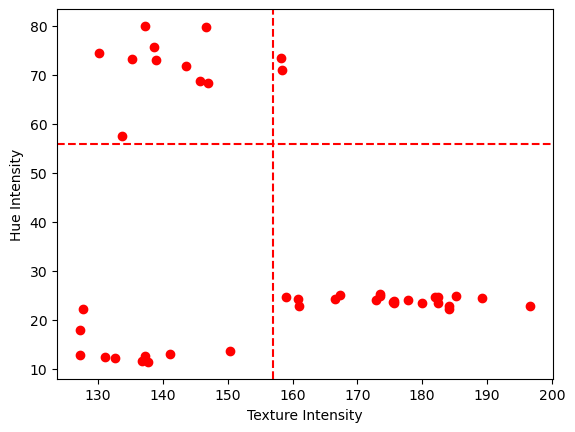

In [9]:
# *** Calculate features for each object:
features = np.zeros((len(properties), 2))

for i in range(0, len(properties)):
    features[i, 0] = gabor_properties[i].mean_intensity
    features[i, 1] = properties[i].mean_intensity


# Show our objects in the feature space
plt.plot(features[:, 0],features[:, 1], 'ro')
plt.xlabel('Texture Intensity')
plt.ylabel('Hue Intensity')

# *** Choose the thresholds for your features
thrF1 = 157
thrF2 = 56

plt.axvline(x=thrF1,color='r',linestyle='dashed')
plt.axhline(y=thrF2,color='r',linestyle='dashed')
plt.show()

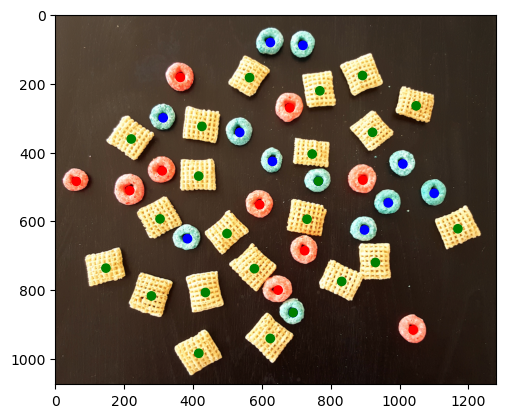

In [10]:
import matplotlib.patches as mpatches

# *** It's time to classify, count and display the objects
squares = 0
blue_circles = 0
red_circles = 0

fig, ax = plt.subplots()
ax.imshow(cv2.cvtColor(sample, cv2.COLOR_BGR2RGB))

for index, obj in enumerate(properties):
  if (features[index,0] < thrF1 and features[index,1] < thrF2):
    red_circles += 1
    
    dot = mpatches.Circle((obj["centroid"][1], obj["centroid"][0]), radius=12, 
                            fill=True, color='red')
    ax.add_patch(dot)

  if (features[index,1] > thrF2):
    blue_circles += 1
    dot = mpatches.Circle((obj["centroid"][1], obj["centroid"][0]), radius=12, 
                    fill=True, color='blue')
    ax.add_patch(dot)

  if (features[index, 0] > thrF1 and features[i, 1] < thrF2):
    squares += 1
    dot = mpatches.Circle((obj["centroid"][1], obj["centroid"][0]), radius=12, 
                           fill=True, color='green')
    ax.add_patch(dot)

plt.show()